## 1. Loading the datasets
Dataset 1 --> Code Red  + Slammer

Ratio features: NO

Training: Code Red 559 1 Min + Slammer 559 1 Min

Test: Nimda 559 1 Min

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# Import explainability libraries if installed
try:
    import shap
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Loading the training dataset

In [2]:
# Load the first training dataset - update the path to the dataset file you want to use
dataset_path = "../datasets/dataset_slammer_559_1_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7200, 52)


,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
0,0,0,0,3,7,6,0,0,0.000000,0,...,0,0,0.0,0,2003-01-23 00:00:08,1043280008,7,6,0,0
1,1,0,0,3,5,6,0,1,0.000000,1,...,0,0,0.0,0,2003-01-23 00:01:08,1043280068,5,6,0,26
2,2,0,0,7,4,4,0,0,0.000000,7,...,0,0,0.0,0,2003-01-23 00:02:08,1043280128,4,4,0,5
3,3,0,0,21,4,6,0,0,0.000000,20,...,0,0,0.0,0,2003-01-23 00:03:08,1043280188,4,6,0,4
4,4,0,4,12,7,9,0,0,2.285714,3,...,0,0,0.0,0,2003-01-23 00:04:08,1043280248,7,7,0,25


In [3]:
# Load the second training dataset - update the path to the dataset file you want to use
dataset_path = "../datasets/dataset_code-red_559_1_rrc04.csv"
df_2 = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df_2.shape}")
df_2.head()

Dataset shape: (7136, 52)


,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
0,0,5,107,115,4,11,0,2,2.060870,3,...,5,0,0.0,0,2001-07-17 00:50:50,995331050,4,8,0,2
1,1,2,1,8,8,12,0,0,2.600000,0,...,1,0,0.0,0,2001-07-17 00:51:50,995331110,8,9,0,7
2,2,3,1,20,5,13,0,8,0.666667,14,...,5,0,0.0,0,2001-07-17 00:52:50,995331170,5,10,0,14
3,3,7,1,27,4,17,0,5,2.160000,17,...,8,0,0.0,0,2001-07-17 00:53:50,995331230,4,14,0,7
4,4,4,1,21,6,7,0,5,1.000000,12,...,5,0,0.0,0,2001-07-17 00:54:50,995331290,6,7,0,0


In [4]:
# Combine the training data
df = pd.concat([df, df_2])
print(f"Dataset shape: {df.shape}")

Dataset shape: (14336, 52)


### 1.2 Loading the testing dataset

In [5]:
# Load the test dataset
dataset_path = "../datasets/dataset_nimda_559_1_rrc04.csv"   # CHANGE THIS
df_test = pd.read_csv(dataset_path)
df_test.head()

,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
0,0,19,1,38,9,15,0,0,2.428571,0,...,0,0,0.0,0,2001-09-15 20:13:25,1000584805,6,11,0,3
1,1,18,1,43,7,14,0,5,1.880000,6,...,1,1,0.0,0,2001-09-15 20:14:25,1000584865,5,10,0,17
2,2,0,1,9,5,10,0,1,0.666667,5,...,2,2,0.0,0,2001-09-15 20:15:25,1000584925,5,7,0,18
3,3,8,0,39,10,10,0,22,0.974359,23,...,4,0,0.0,0,2001-09-15 20:16:25,1000584985,9,9,0,1
4,4,5,35,73,5,10,0,22,2.191781,23,...,9,0,0.0,0,2001-09-15 20:17:25,1000585045,5,9,0,0


## 2. Data Exploration and Preprocessing

### 2.1 Training Dataset

In [6]:
# Check basic statistics
df.describe()

,Unnamed: 0,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,...,origin_1,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals
count,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,...,14336.000000,14336.000000,14336.000000,14336.000000,14336.000000,1.433600e+04,14336.000000,14336.000000,14336.0,14336.000000
mean,3583.571429,6.925432,6.499930,33.774275,6.155483,8.872489,0.111747,3.089844,1.488181,13.945661,...,0.027134,1.702079,0.195382,0.034676,0.321708,1.019628e+09,5.668666,6.870536,0.0,13.909877
std,2069.419234,30.875459,21.740092,198.752168,2.583660,3.308853,0.315065,18.276667,1.210744,138.032015,...,0.250350,4.427225,1.127756,0.124102,0.624479,2.397636e+07,2.047980,1.973096,0.0,281.216327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.953310e+08,0.000000,0.000000,0.0,0.000000
25%,1791.750000,0.000000,0.000000,5.000000,5.000000,7.000000,0.000000,0.000000,0.542657,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.955461e+08,4.000000,6.000000,0.0,1.000000
50%,3583.500000,2.000000,2.000000,12.000000,6.000000,9.000000,0.000000,0.000000,1.344952,4.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.043282e+09,6.000000,7.000000,0.0,3.000000
75%,5375.250000,5.000000,5.000000,27.000000,7.000000,11.000000,0.000000,2.000000,2.111111,10.000000,...,0.000000,2.000000,0.000000,0.000325,1.000000,1.043497e+09,7.000000,8.000000,0.0,8.000000
max,7199.000000,2562.000000,598.000000,14460.000000,28.000000,24.000000,1.000000,663.000000,12.000000,14273.000000,...,8.000000,280.000000,54.000000,3.000000,7.000000,1.043712e+09,22.000000,15.000000,0.0,29376.000000


In [7]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0                      0
ann_to_longer                   0
ann_to_shorter                  0
announcements                   0
as_path_avg                     0
as_path_max                     0
class                           0
dups                            0
edit_distance_avg               0
edit_distance_dict_0            0
edit_distance_dict_1            0
edit_distance_dict_10           0
edit_distance_dict_2            0
edit_distance_dict_3            0
edit_distance_dict_4            0
edit_distance_dict_5            0
edit_distance_dict_6            0
edit_distance_dict_7            0
edit_distance_dict_8            0
edit_distance_dict_9            0
edit_distance_max               0
edit_distance_unique_dict_0     0
edit_distance_unique_dict_1     0
edit_distance_unique_dict_10    0
edit_distance_unique_dict_2     0
edit_distance_unique_dict_3     0
edit_distance_unique_dict_4     0
edit_distance_unique_dict_5     0
edit_distance_unique_dict_6     0
edit_distance_

In [8]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    12734
1     1602
Name: count, dtype: int64


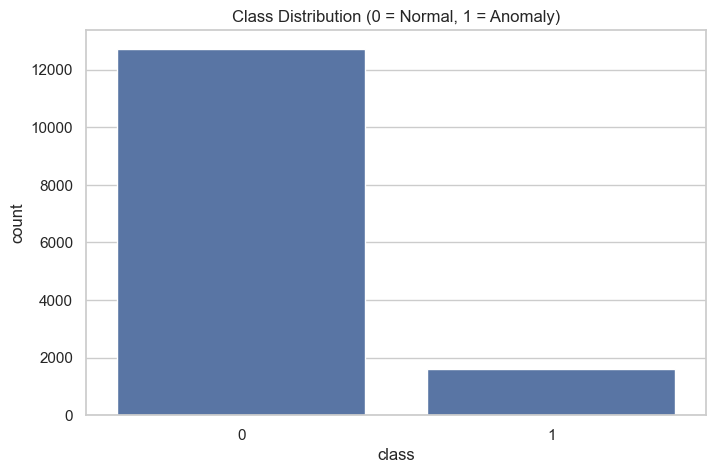

In [9]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [10]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 48
Feature names:


['ann_to_longer',
 'ann_to_shorter',
 'announcements',
 'as_path_avg',
 'as_path_max',
 'dups',
 'edit_distance_avg',
 'edit_distance_dict_0',
 'edit_distance_dict_1',
 'edit_distance_dict_10',
 'edit_distance_dict_2',
 'edit_distance_dict_3',
 'edit_distance_dict_4',
 'edit_distance_dict_5',
 'edit_distance_dict_6',
 'edit_distance_dict_7',
 'edit_distance_dict_8',
 'edit_distance_dict_9',
 'edit_distance_max',
 'edit_distance_unique_dict_0',
 'edit_distance_unique_dict_1',
 'edit_distance_unique_dict_10',
 'edit_distance_unique_dict_2',
 'edit_distance_unique_dict_3',
 'edit_distance_unique_dict_4',
 'edit_distance_unique_dict_5',
 'edit_distance_unique_dict_6',
 'edit_distance_unique_dict_7',
 'edit_distance_unique_dict_8',
 'edit_distance_unique_dict_9',
 'flaps',
 'imp_wd',
 'imp_wd_dpath',
 'imp_wd_spath',
 'nadas',
 'news',
 'nlri_ann',
 'number_rare_ases',
 'origin_0',
 'origin_1',
 'origin_2',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'unique_as_path_avg',
 'uniq

### 2.2 Test Dataset

In [11]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)
y_test = df_test["class"]
X_test = df_test.drop(["class"], axis=1)

## 3. Feature Analysis and Selection

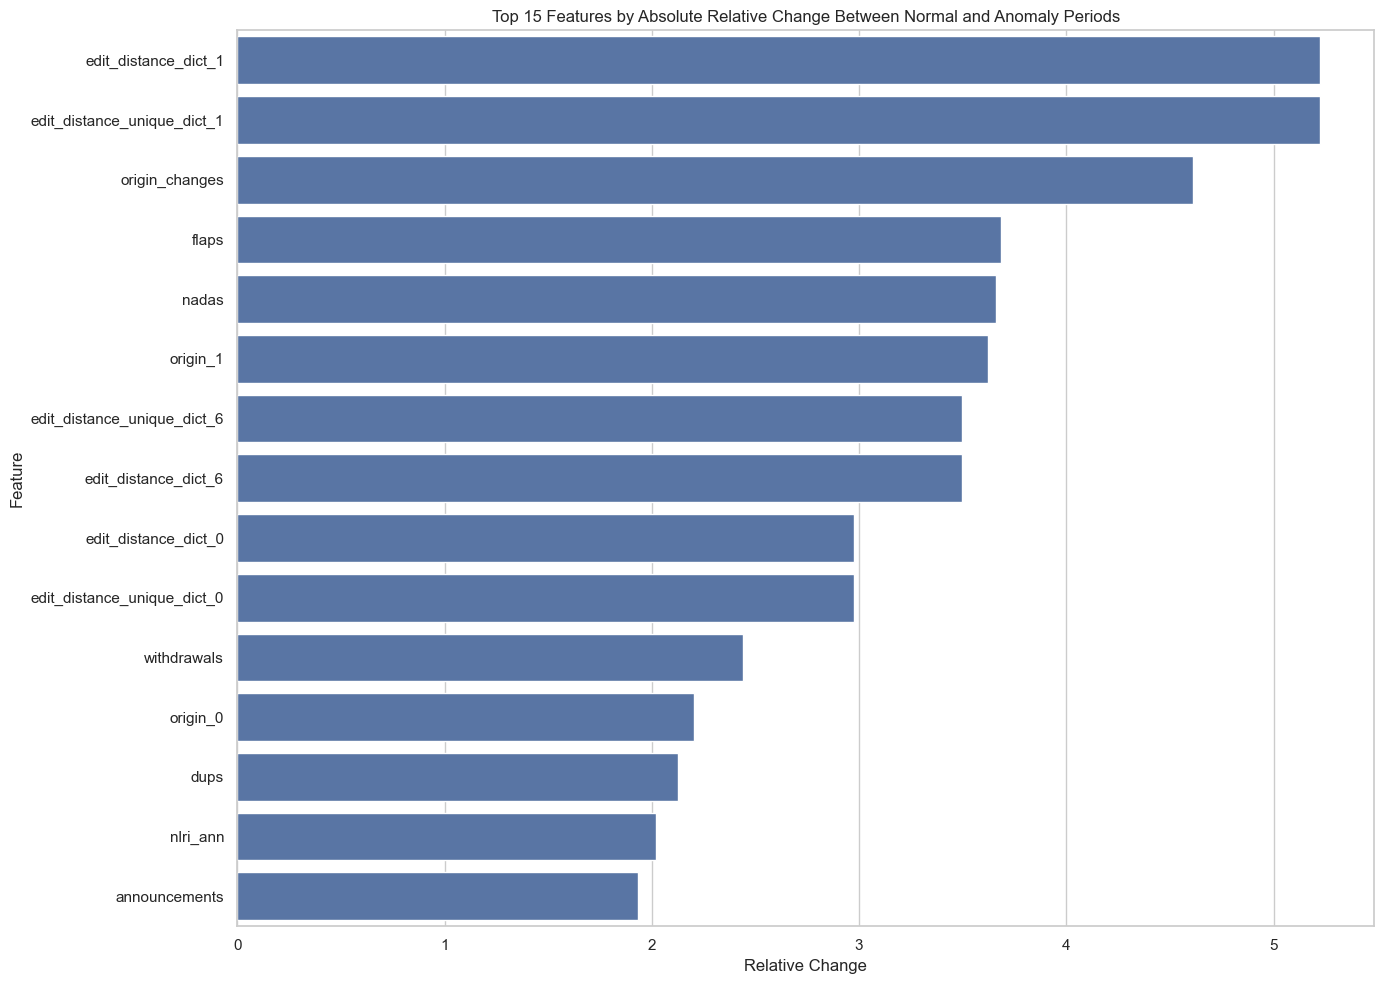

In [12]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [13]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X = X[top_features]
X_test = X_test[top_features]

Selected top features:
['edit_distance_dict_1', 'edit_distance_unique_dict_1', 'origin_changes', 'flaps', 'nadas', 'origin_1', 'edit_distance_unique_dict_6', 'edit_distance_dict_6', 'edit_distance_dict_0', 'edit_distance_unique_dict_0', 'withdrawals', 'origin_0', 'dups', 'nlri_ann', 'announcements']


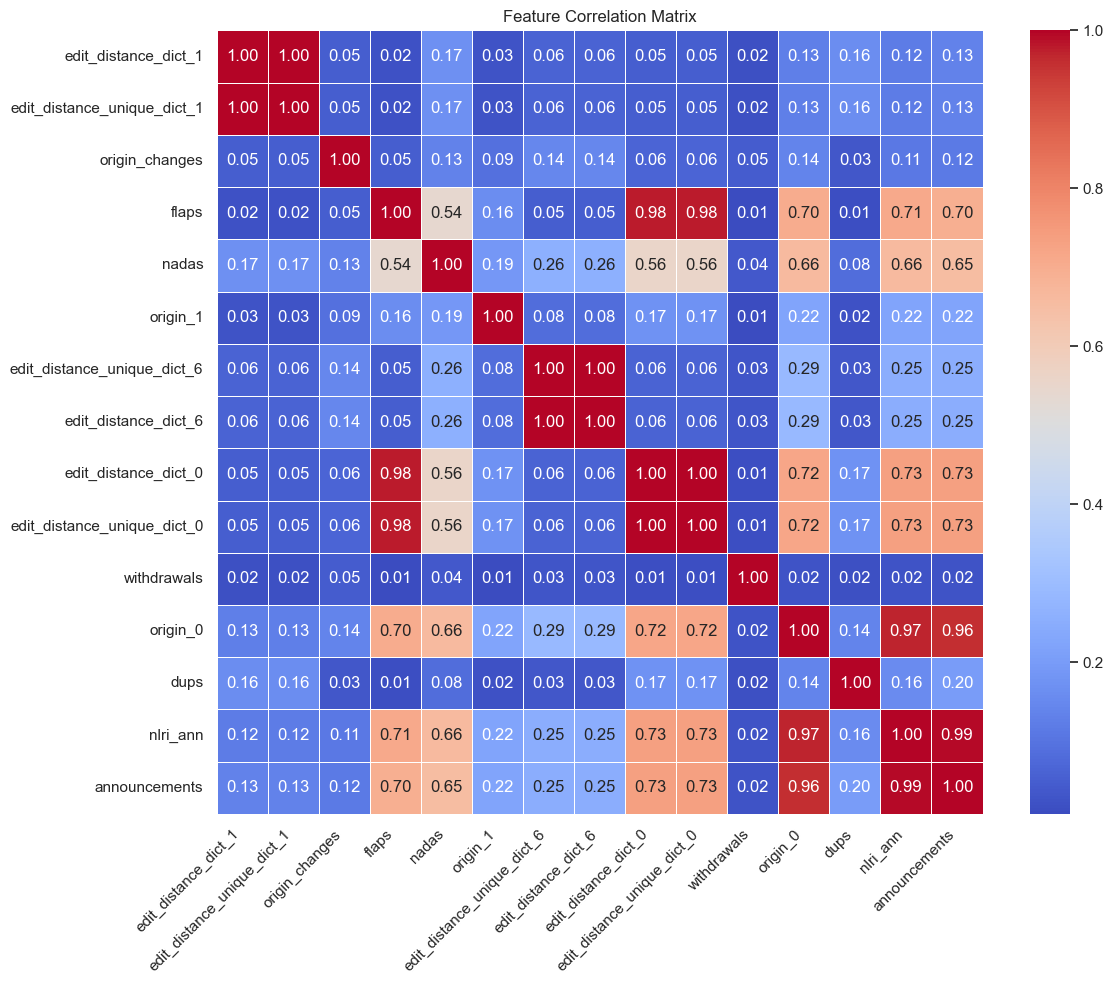

In [14]:
# Feature Correlation Matrix
feature_cols = X.select_dtypes(include=['number']).columns
X_features = df[feature_cols]
corr_matrix = X_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. SVM Model Training and Hyperparameter Tuning

In [15]:
X_train = X
y_train = y

In [16]:
# Balance classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution
print(Counter(y_train))

Counter({0: 12734, 1: 12734})


In [ ]:
# Create a pipeline with preprocessing and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Define the hyperparameter search space
param_grid = {
    'svm__C': [0.1, 1, 10],            
    'svm__gamma': ['scale', 0.01],      
    'svm__kernel': ['rbf']          
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

## 5. Model Evaluation with Advanced Metrics

In [ ]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
# Support vectors
svm = best_model.named_steps['svm']
support_vectors = svm.support_vectors_
print(f"Number of support vectors: {len(support_vectors)}")

In [ ]:
# Plot margin distances
distances = svm.decision_function(X_test)  # signed distance to margin

plt.figure(figsize=(8, 8))
plt.xlim(-6, 2)
sns.histplot(distances[y_test == 0], color='blue', label='Normal', kde=True, stat='density', bins=50)
sns.histplot(distances[y_test == 1], color='orange', label='Anomaly', kde=True, stat='density', bins=50)
plt.axvline(0, color='black', linestyle='--', label='Decision Boundary')
plt.title("SVM Margin Distance Distribution by True Class")
plt.xlabel("Decision Function Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot misclassifications
y_pred = svm.predict(X_test)

# Get false positives and false negatives
fp = (y_test == 0) & (y_pred == 1)
fn = (y_test == 1) & (y_pred == 0)

plt.scatter(range(len(distances[fp])), distances[fp], color='red', label='False Positives')
plt.scatter(range(len(distances[fn])), distances[fn], color='purple', label='False Negatives')
plt.axhline(0, color='black', linestyle='--')
plt.title("Margin Distances of Misclassified Points")
plt.ylabel("Distance to Decision Boundary")
plt.legend()
plt.show()

In [ ]:
# T-SNE projection
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test)

# Plot with true labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test)
plt.title("t-SNE Projection Colored by True Class")
plt.show()

# Plot with predicted labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=svm.predict(X_test))
plt.title("t-SNE Projection Colored by Predicted Class")
plt.show()

In [ ]:
# PCA
# Apply PCA to reduce to 2 dimensions for visualization
dims = 2
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=dims)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_train.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

loadings = pca.components_.T  # shape: (original_features, 21)
loading_df = pd.DataFrame(loadings, index=df.columns, columns=[f"PC{i+1}" for i in range(dims)])

# View top contributing features to PC1
print("Top features for PC1:")
print(loading_df['PC1'].abs().sort_values(ascending=False).head(5))

In [ ]:
# SHAP Explanations
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_train.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_train.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")